In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from file_lists import get_file_list
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='royalblue'> Read the data (test runs below 15 seconds)

In [2]:
file_path = "E:\POSITION DATA\PRE PROCESSED/below15_runs.csv"
below15 = pd.read_csv(file_path)
below15.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,2.989453,4.061312,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971


### <font color='royalblue'>Remove pre-illuminated and sample illuminated trials


In [3]:
below15 = below15[(below15['stim_condition']==0)|(below15['stim_condition']==3)]
below15['stim_condition'].unique()

array([3, 0], dtype=int64)

### <font color='royalblue'> Collect the viral expression times of each rat

In [4]:
file_path = "E:\expression_times.csv"
expression_times = pd.read_csv(file_path)

In [5]:
expression_times.head()

,group,rat,total_time,stim_time
0,CTRL,CTRL1,12,9
1,CTRL,CTRL2,13,10
2,CTRL,CTRL3,8,5
3,CTRL,CTRL4,10,7
4,CTRL,CTRL5,8,5


### <font color='royalblue'> Calculate the performances

In [6]:
# Calculate performances for each rat, session and stimulation condition
session_perfs = below15.groupby(['group','rat','session', 'stim_condition']).apply(calc_performance_in_group)

In [7]:
session_perfs = session_perfs.reset_index().rename(columns={0:'performance'})

In [8]:
pooled_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition'])['performance'].mean().reset_index()

### <font color='royalblue'> Calculate the median latencies

In [9]:
median_latencies = below15.groupby(['group','rat','session', 'stim_condition'])['latency_to_cp_entry'].median().reset_index()

In [10]:
median_latencies.head()

,group,rat,session,stim_condition,latency_to_cp_entry
0,CTRL,CTRL2,2020-02-07T14_40_27,0,3.637888
1,CTRL,CTRL2,2020-02-07T14_40_27,3,3.343014
2,CTRL,CTRL2,2020-02-08T10_24_17,0,1.854938
3,CTRL,CTRL2,2020-02-08T10_24_17,3,2.712755
4,CTRL,CTRL2,2020-02-09T10_17_11,0,1.914150


### <font color='royalblue'> Concatentate the viral expression times and the performances

In [11]:
session_perfs['expression_stim_time']=""

for rat in expression_times['rat'].unique():
    
    stim_time = expression_times.loc[expression_times['rat']==rat,'stim_time']
    session_perfs.loc[session_perfs['rat']==rat, 'expression_stim_time']=stim_time.iloc[0]
    median_latencies.loc[median_latencies['rat']==rat, 'expression_stim_time']=stim_time.iloc[0]

### <font color='royalblue'> Add the session number

In [34]:
# Create a rat-to-session labels mapping
nphrs_performances = session_perfs[session_perfs['group']=='NPHR']
rat_to_session_map= nphrs.sort_values(by=['rat','session']).groupby(
    ['rat','session']).nth(0).reset_index()[['rat','session']]

In [35]:
#Collect the first x session_labels
session_labels = rat_to_session_map.groupby(['rat'])['session'].head(10)

# Get the first x performances
nphrs_performances = nphrs_performances[nphrs_performances['session'].isin(session_labels)]
illum_performances = nphrs_performances[nphrs_performances['stim_condition']==3]

#Get the first x median latencies
nphr_latencies = median_latencies[median_latencies['session'].isin(session_labels)]
illum_latencies = nphr_latencies[nphr_latencies['stim_condition']==3]

### <font color='royalblue'> Scatter plot session illumination performances (first 5) with viral expression time during the start of the protocol

<Figure size 1800x1200 with 0 Axes>

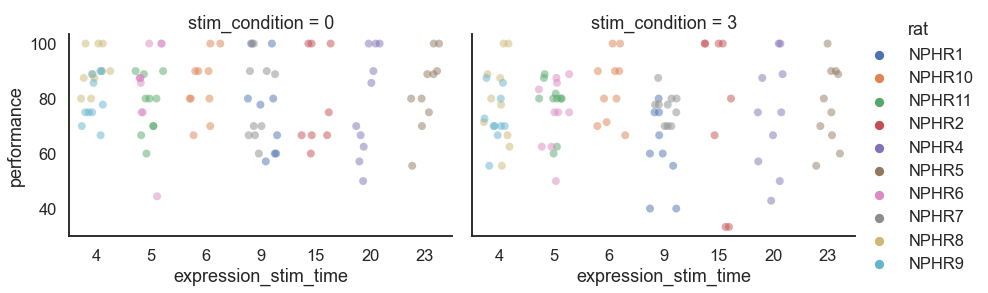

In [41]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
sns.catplot(kind='strip', col='stim_condition', data=nphrs_performances, x='expression_stim_time', y='performance',
            hue='rat', alpha=.5, s=8, height=4, aspect=1.5, jitter=.3)
sns.despine()

### <font color='royalblue'> Plot Median Latencies with viral expression time

<Figure size 1800x1200 with 0 Axes>

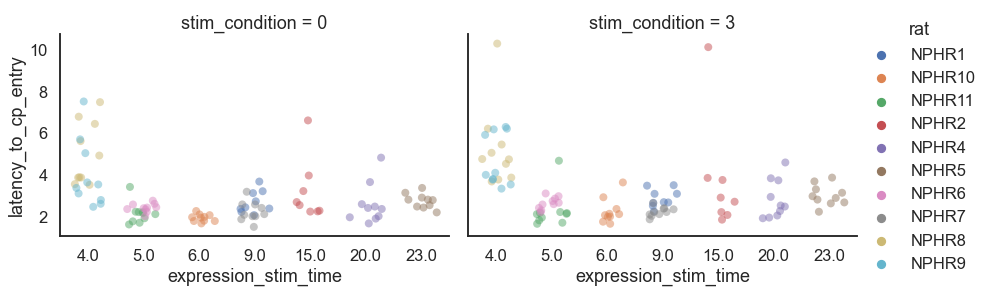

In [38]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
sns.catplot(kind='strip', data=nphr_latencies, col='stim_condition', x='expression_stim_time', y='latency_to_cp_entry', hue='rat',
            alpha=.5, s=8, height=4, aspect=1.5, jitter=.3)
sns.despine()

In [33]:
nphr_latencies[nphr_latencies['expression_stim_time']<5]['rat'].unique()

array(['NPHR8', 'NPHR9'], dtype=object)